In [427]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
from tqdm import tqdm
from IPython.display import clear_output

We generate a tree randomly and traverse it at the same time. This is more efficient than generating trees beforehand.

We use the following strategy:
1. Generate a new node with probability $\theta$ of being an $A$ node, and $1-\theta$ of being an $S$ node
    1. If the node is an $S$ node we cannot continue ($R_S=0$!) and return to the previous generation $g$
    2. If the node is an $A$ node we can continue ($R_0=2$). We create $R_0=2$ new nodes according to 1.

In [3]:
def spread(g, theta):
    if g == 0 or theta == 1:
        # break if last generation is reached
        # also break if theta == 1 since theta = 1 forces percolation
        # -> no need for calculation
        return True
    else:
        if rand.uniform(0,1) <= theta:
            # generate an 'A' node with probability theta
            
            # in order to avoid unneccessary calculation we first check
            # if the left branch percolates, if so we return true
            left = spread(g-1, theta)
            if left:
                return True
            # if the left branch didn't percolate we check the right branch
            # (Remember that R_0=2, so we have two branches!)
            right = spread(g-1, theta)
            if right:
                return True
            # if the right branch didn't percolate either we return False
            # -> subbranch didn't percolate so move up one layer
            else:
                return False
        else:
            # 'S' node was generated.
            # R_S=0, so the node cannot percolate -> return false
            return False
        
    
thetas = np.linspace(0,1,100) # scan 100 theta values
mus = [] # stores mean value for probability of percolation
sigmas = [] # stores the associated standard deviation
for theta in thetas:
    res = np.array([spread(700, theta) for i in range(300)])
    mus.append(res.mean())
    sigmas.append(res.std())
    
mus = np.array(mus)
sigmas = np.array(sigmas)/np.sqrt(len(sigmas)) # calculate standard error

After executing the above code we plot our results below.

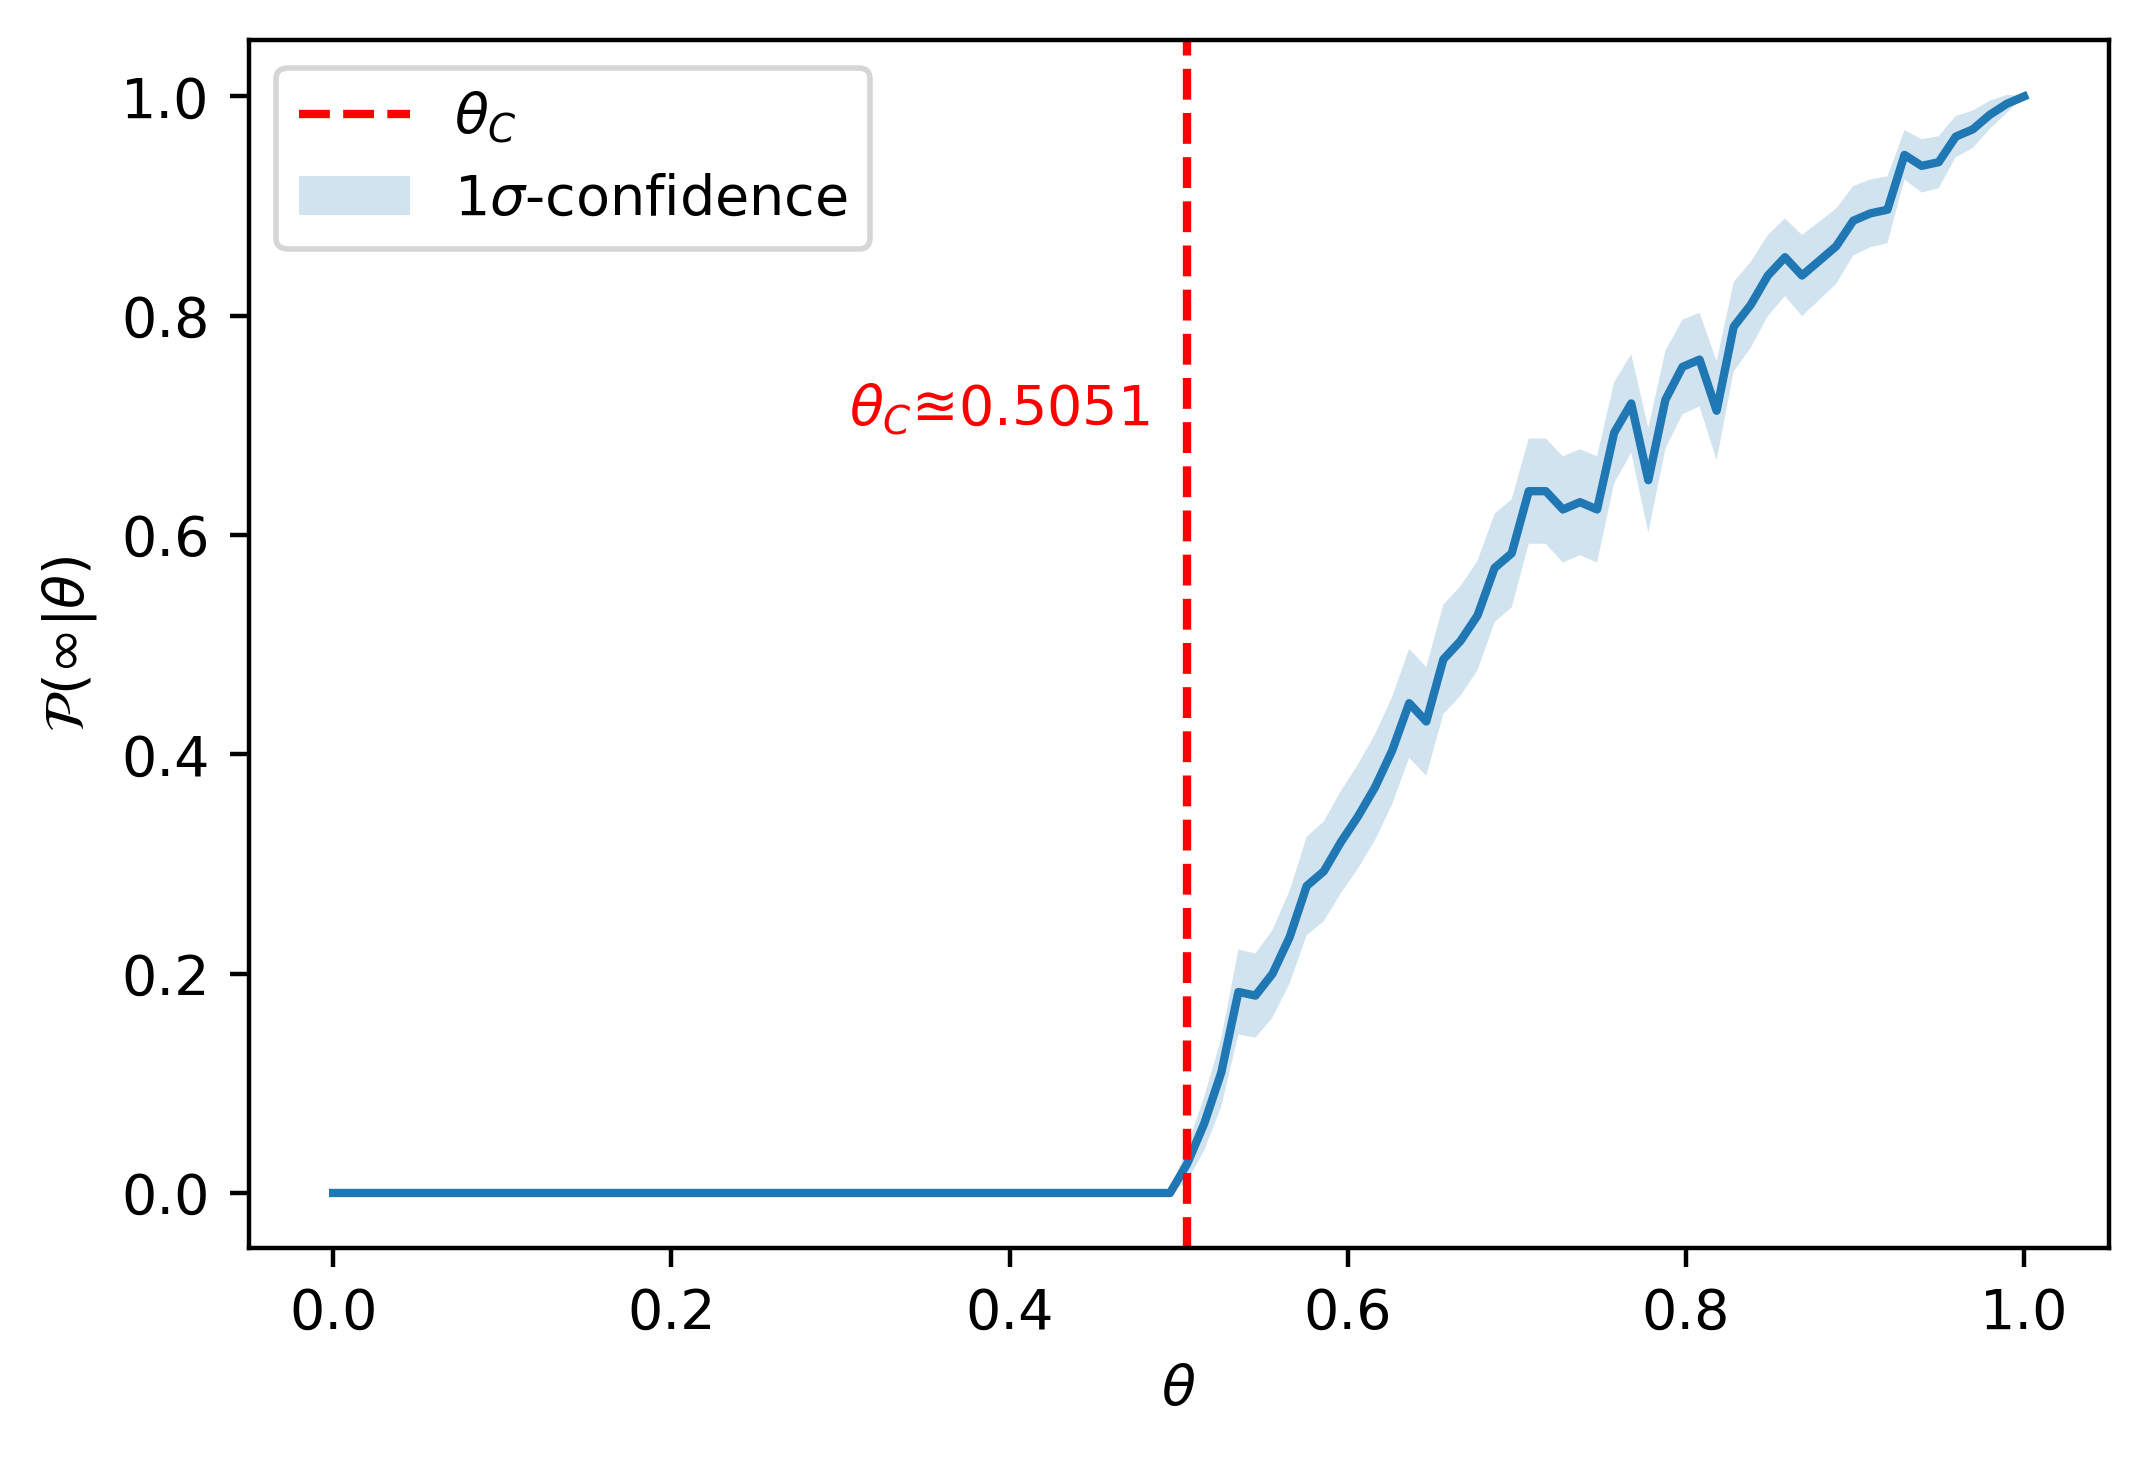

In [4]:
# PLOTTING
fig, ax = plt.subplots(dpi=400)
ax.plot(thetas, mus)
ax.set_ylabel(r"$\mathcal{P}(\infty|\theta)$")
ax.set_xlabel(r"$\theta$")
ax.axvline(thetas[np.argwhere(mus > 0)[0]], c="r", linestyle="--", label=r"$\theta_C$")
ax.annotate(r"$\theta_C\approxeq $" + str(round(float(thetas[np.argwhere(mus > 0)[0]]), 4)), (thetas[np.argwhere(mus > 0)[0]] - 0.2, 0.7), color="r")
ax.fill_between(thetas, mus+sigmas, mus-sigmas, alpha=0.2, label=r"$1\sigma$-confidence")
ax.legend()

We see the typical probability distribution for percolation on a Cayley tree, albeit at a different critical probability $\theta_C$ corresponding to $R_0=2$. We can see that for a generation depth of $g=700$ the fraction of asymptotic persons would need to be $\theta=\theta_C\approx\frac{1}{2}$ for COVID-19 to achieve percolation.

However, the generation depth of 700 is hardly realistic given that there are roughly $N_{earth}7.8\cdot 10^{9}$ people on this planet we would run out of people after

$$
7.8\cdot 10^{9}\overset{!}{=}2^{g_{max}}\Longleftrightarrow g_{max}=\log_2(7.8\cdot 10^{9})
$$

generations.

In [5]:
print("g_max={0}".format(round(np.log2(7.8e9))))

g_max=33.0


# b)

We first create a class ```Node``` to represent the nodes of the Cayley Tree.
Aside from some quality of life features, the class features the following functions:
1. ```add_child```
2. ```trace```

```add_child``` (as the name implies) appends a node the the current node. 
**Note**: No logic is implemented for this function. The logic for whether a node can be added or not is solely handeled by recursion later!

```trace``` traces the path of the node back to it's origin. Returning a string of parent nodes.

In [782]:
class Node:
    R_0 = 3
    R_S = 2
    phi = 0.5
    theta = 0.5
    quarantined = False
    
    def __repr__(self):
        return "Node (state: \"{0}\", parent state: \"{1}\", quarantined: \"{2}\", children: \"{3}\")".format(self.state, self.parent.state if self.parent is not None else None, self.quarantined, len(self.children))
    
    def __init__(self, state, parent=None, quarantined=False):
        if state not in ["CS", "NS", "CA", "NA", "inactive"]:
            raise ValueError("Invalid state")
        self.children = []
        self.parent = parent
        self.state = state
        self.id = id(self)
        self.quarantined = quarantined
        
    def add_child(self, state):
        child = (Node(state, parent=self))
        self.children.append(child)
        return child
    
    def trace(self, node=None, anchor="", rev=True):
        if node is None:
            node = self
            anchor += self.state
        if node.parent is None:
            if rev:
                l = anchor.split("-")
                l = l[::-1]
                anchor = "-".join(l)
            return anchor 
        return self.trace(node.parent, anchor + "-" + node.parent.state, rev=rev)

After having created the class we run some verifications to make sure we have actually implemented the behaviour correctly.

Firstly we test whether we can reach patient zero from child nodes. Given our current class we should be able to simply daisy-chain the parent property $n$ time to give us the $n$-th parent node.

**Note**: We call the ```add_child``` function directly for consistent testing, as the ```add_generation``` function populates the grid in a random fashion, and doesn't continue the branch for nodes in quarantine. However, since the ```add_generation``` function simply calls the ```add_child``` function after some logic determining how many children should be added and in what state, the vertical structure will be untouched, and our test is representative for both functions.

Consider the following vertical structure: $NS\to NA\to NA\to CS\to CA$

In [783]:
p = Node("NS")
c = p.add_child("NA")
gc = c.add_child("NA")
ggc = gc.add_child("CS")
gggc = ggc.add_child("CA")
for n in [p, c, gc, ggc, gggc]:
    print(n)

Node (state: "NS", parent state: "None", quarantined: "False", children: "1")
Node (state: "NA", parent state: "NS", quarantined: "False", children: "1")
Node (state: "NA", parent state: "NA", quarantined: "False", children: "1")
Node (state: "CS", parent state: "NA", quarantined: "False", children: "1")
Node (state: "CA", parent state: "CS", quarantined: "False", children: "0")


To see now if we can reach patient zero from the bottommost node, we repeatedly call ```gggc.parent```.

In [784]:
id(p) == id(gggc.parent.parent.parent.parent)

True

Finally we trace the path back to the root node by virtue of the ```trace``` function.

In [786]:
gggc.trace(rev=True)

'NS-NA-NA-CS-CA'

Next we build a ```infect``` function. This recursive function takes in a ```node``` object as well as $\phi$ and $\theta$ values. With a maximum recursion depth of 10, we recursively build the Cayley tree from a starting node.
This function takes the effect of the tracking network into account while building the tree to reduce computational overhead.

The tracking network is represented by a ```quarantine``` recursive function, which is invoked whenever the ```infect``` function encounters a $CS$ node. The function then recursively travereses the tree forwards and backwards - breaking recursing when encountering an $NS$ or $NA$ node. All traversed nodes are flagged with the ```quarantine``` flag. The quarantine flag prohibits the ```infect``` method from growing a flagged node.

```infect``` starts from a root node. Since the root node cannot be in quarantine, 2 nodes are created for a $NS$, $CS$ root, and each of them is passed to a recursive call to ```infect```. Starting from the second generation some logic needs to be applied to the recursion.
1. check whether a node is quarantined $\rightarrow$ end recursion
2. check whether the node is a $CS$ node, if so we invoke the ```quarantine``` function $\rightarrow$ continue recursion
3. check whether the node is symptomatic or not $\rightarrow$ create $R_S$ or $R_0$ children $\rightarrow$ continue recursion
4. check if maximum recursion depth has been reached $\rightarrow$ end recursion

For each branch the recursion ends when either the maximum recursion depth has been reached or it's nodes have been quarantined.

In [ ]:
phi = 0.9
theta = 0.5
R_0 = 3
R_S = 2 
gen_state = lambda phi, theta: ("C" if rand.uniform(0,1) <= phi else "N") + ("A" if rand.uniform(0,1) <= theta else "S")

def check_perc(node):
    if len(node.children) == 0:
        yield True if not node.quarantined else False
    else:
        for c in node.children:
            yield from check_perc(c)

def quarantine(node):
    yield node
    if node is not None and node.state[0] == "C" and not node.quarantined:
        node.quarantined = True
        yield from quarantine(node.parent)
        for c in node.children:
            if c.state[0] == "C":
                yield from quarantine(c)
    else:
        yield None

def infect(node, phi=0.5, theta=0.5, gen=0):
    if gen > 10:
        return None
    yield node
    if node.quarantined:
        yield None
    if node.parent == None:
        for n in range(R_S) if node.state[1] == "S" else range(R_0):
            node.add_child(gen_state(phi, theta))

        for c in node.children:
                yield from infect(c, phi, theta, gen+1)
    else:
        '''
        if node.parent.state[0] == "C" and node.state[0] == "C":
            node.parent.quarantined = True
            for c in node.parent.children:
                c.quarantined = True if c.state[0] == "C" else False
            yield None
        '''
        if node.state == "CS":
            list(quarantine(node))
            yield None
        else:
            #yield node
            for n in range(R_S) if node.state[1] == "S" else range(R_0):
                node.add_child(gen_state(phi, theta))
            
            for c in node.children:
                yield from infect(c, phi, theta, gen+1)
        

N = 10
M = 10
L = 10

out = np.zeros((N,M,L))
for n, phi in enumerate(tqdm(np.linspace(0.1,1,N))):
    for m, theta in enumerate((np.linspace(0.1,1,M))):
        for l in (range(L)):
            net = infect(Node("CS"), phi, theta)
            anchor = list(net)
            out[n,m,l] = max(check_perc(anchor[0]))

After performing a parameter scan over $\phi$ and $\theta$ and averaging over $L=10$ trees, we plot the results below. The white line represents the critical line for $R_S=0$ as requested by the problem set.

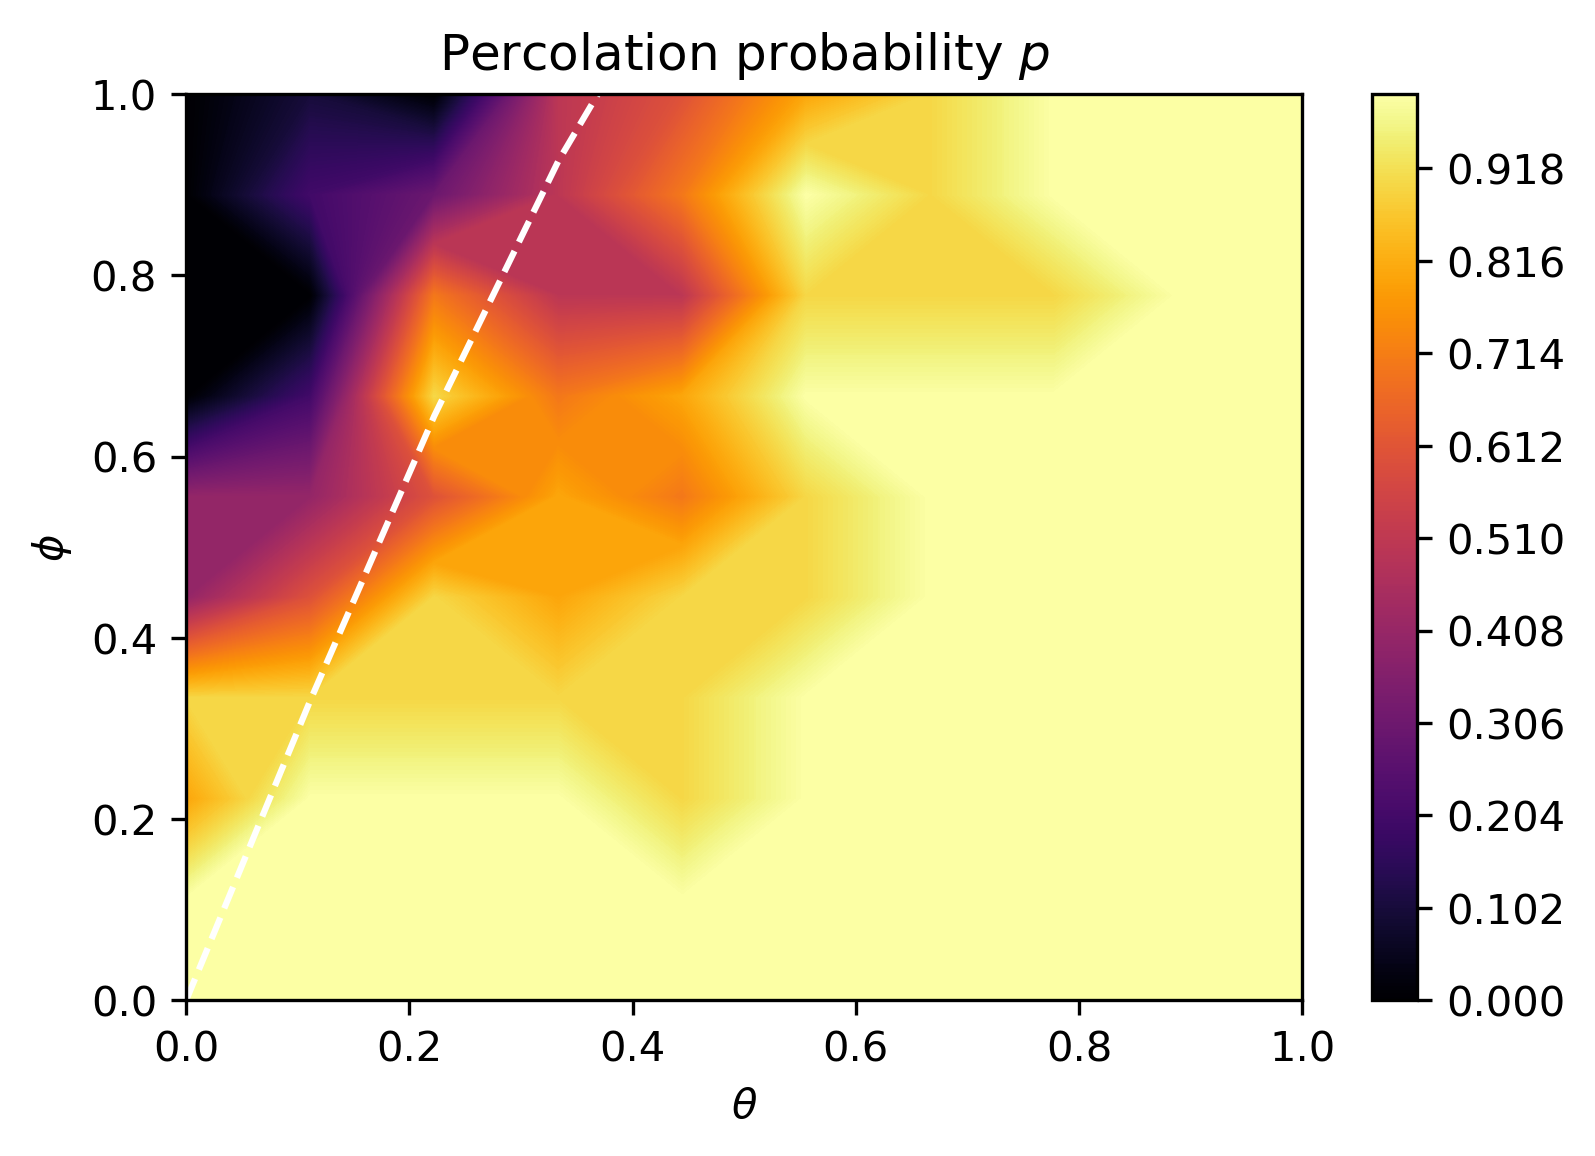

In [779]:
mean = out.sum(axis=2)/out.shape[2]
fig, ax = plt.subplots(dpi=300)
x = y = np.linspace(0,1, 10)
cont = ax.contourf(x,y,mean, 500, cmap="inferno")
ax.set_ylabel(r"$\phi$")
ax.set_xlabel(r"$\theta$")
ax.set_title("Percolation probability $p$")
ax.plot(x, R(x,y,3,0), c="white", linestyle="--")
ax.set_ylim(0,1)
fig.colorbar(cont, ax=ax)

We see, that for a large fraction $\phi$ we can prevent percolation of the system. However this is only possible if $\theta$ is sufficiently low. Furthermore there is an intermediate region, where percolation is still possible, but isn't certain. Only in the regimes of small $\phi$ and large $\theta$ percolation becomes inevitable.
The critical line separates the regimes of unlikely percolation and likely/certain percolation. The fact that the critical line does not yield a clear separation of regimes is likely due to the low resolution of the grid with only 10 scans per parameter.